In [169]:
import time

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.distributions import Categorical

In [170]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [171]:
env = gym.make("CartPole-v1")

In [172]:
ACTION_SIZE = env.action_space.n
STATE_SIZE = env.observation_space.shape[0]

MAX_STEPS = 500
NUM_EPISODES = 200
DISCOUNT_FACTOR = 0.99
DECAY_RATE = 0.97

ACTOR_LEARNING_RATE = 0.0003
CRITIC_LEARNING_RATE = 0.001

CLIP_VALUE = 0.2
KL_DIV_VALUE = 0.01
VALUE_TRAINING_ITERATIONS = 40
POLICY_TRAINING_ITERATIONS = 40

In [178]:
class ActorCriticNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(ActorCriticNetwork, self).__init__()
        self.shared_layers = nn.Sequential(nn.Linear(state_size, 64), nn.ReLU())

        self.critic_layer = nn.Sequential(
            nn.Linear(64, 64), nn.ReLU(), nn.Linear(64, 1)
        )
        self.actor_layer = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_size),
        )

    def policy(self, x):
        x = self.shared_layers(x)
        return self.actor_layer(x)

    def value(self, x):
        x = self.shared_layers(x)
        return self.critic_layer(x)

    def forward(self, x):
        x = self.shared_layers(x)
        policy = self.actor_layer(x)
        value = self.critic_layer(x)
        return policy, value

In [ ]:
class PPOTrainer:
    def __init__(
        self,
        env: gym.Env,
        actor_critic_model: ActorCriticNetwork,
        max_steps,
        num_episodes,
        discount_rate,
        decay_rate,
        actor_lr,
        critic_lr,
        clip_val,
        kl_divergence_val,
        policy_train_iters,
        value_train_iters,
    ):
        self.env = env
        self.max_steps = max_steps
        self.num_episodes = num_episodes
        self.discount_rate = discount_rate
        self.decay_rate = decay_rate
        self.actor_critic_model = actor_critic_model
        self.clip_val = clip_val
        self.target_kl_divergence = kl_divergence_val
        self.policy_train_iters = policy_train_iters
        self.value_train_iters = value_train_iters

        policy_params = list(self.actor_critic_model.shared_layers.parameters()) + list(
            self.actor_critic_model.actor_layer.parameters()
        )
        value_params = list(self.actor_critic_model.shared_layers.parameters()) + list(
            self.actor_critic_model.critic_layer.parameters()
        )

        self.policy_optimizer = torch.optim.Adam(policy_params, lr=actor_lr)
        self.value_optimizer = torch.optim.Adam(value_params, lr=critic_lr)

    def rollout(self) -> tuple[list, float]:
        # state, action, reward, values, action_log_prob
        training_data = [[], [], [], [], []]
        episode_reward = 0

        state, _ = self.env.reset()
        self.actor_critic_model.eval()
        for _ in range(self.max_steps):
            action_logits, value = self.actor_critic_model(
                torch.tensor(state, dtype=torch.float32).to(device)
            )
            action_distribution = Categorical(logits=action_logits)
            action = action_distribution.sample()
            next_state, reward, terminated, truncated, _ = self.env.step(action.item())

            training_data[0].append(state)
            training_data[1].append(action.item())
            training_data[2].append(reward)
            training_data[3].append(value.item())
            training_data[4].append(action_distribution.log_prob(action).item())

            episode_reward += reward
            state = next_state
            if terminated or truncated:
                break

        training_data = [np.asarray(array) for array in training_data]

        return training_data, episode_reward

    def discount_rewards(self, rewards):
        discounted_rewards = np.zeros_like(rewards, dtype=np.float32)
        last_reward = 0
        for i in reversed(range(len(rewards))):
            last_reward = rewards[i] + self.discount_rate * last_reward
            discounted_rewards[i] = last_reward

        return discounted_rewards

    def calculate_gaes(self, rewards, values):
        next_values = np.append(values[1:], 0)
        deltas = rewards + self.discount_rate * next_values - values
        gaes = np.zeros_like(rewards, dtype=np.float32)
        last_gae = 0
        for i in reversed(range(len(deltas))):
            last_gae = deltas[i] + self.discount_rate * self.decay_rate * last_gae
            gaes[i] = last_gae

        gaes = (gaes - gaes.mean()) / (gaes.std() + 1e-8)
        return gaes

    def train_actor(self, states, actions, old_log_probs, gaes):
        self.actor_critic_model.train()

        for _ in range(self.policy_train_iters):
            new_logits = self.actor_critic_model.policy(states)
            new_logits = Categorical(logits=new_logits)
            new_log_probs = new_logits.log_prob(actions)

            policy_ratio = torch.exp(new_log_probs - old_log_probs)
            clipped_policy_ratio = torch.clamp(
                policy_ratio, 1 - self.clip_val, 1 + self.clip_val
            )
            policy_loss = -torch.min(
                policy_ratio * gaes, clipped_policy_ratio * gaes
            ).mean()

            self.policy_optimizer.zero_grad()
            policy_loss.backward()
            self.policy_optimizer.step()

            kl_div = (old_log_probs - new_log_probs).mean()  # approximate KL-divergence
            if kl_div > self.target_kl_divergence:
                break

    def train_critic(self, states, discounted_rewards):
        self.actor_critic_model.train()

        for _ in range(self.value_train_iters):
            values = self.actor_critic_model.value(states).squeeze()
            value_loss = nn.MSELoss()(values, discounted_rewards)

            self.value_optimizer.zero_grad()
            value_loss.backward()
            self.value_optimizer.step()

    def train(self):
        episode_rewards = []
        for episode_idx in range(self.num_episodes):
            self.actor_critic_model.eval()
            train_data, episode_reward = self.rollout()
            self.actor_critic_model.train()

            episode_rewards.append(episode_reward)

            permuted_indices = np.random.permutation(len(train_data[0]))

            states = torch.tensor(
                train_data[0][permuted_indices], dtype=torch.float32
            ).to(device)
            actions = torch.tensor(
                train_data[1][permuted_indices], dtype=torch.int32
            ).to(device)
            old_log_probs = torch.tensor(train_data[4][permuted_indices]).to(device)

            discounted_rewards = torch.tensor(
                self.discount_rewards(train_data[2])[permuted_indices],
                dtype=torch.float32,
            ).to(device)
            gaes = torch.tensor(
                self.calculate_gaes(train_data[2], train_data[3])[permuted_indices],
                dtype=torch.float32,
            ).to(device)

            self.train_actor(states, actions, old_log_probs, gaes)
            self.train_critic(states, discounted_rewards)

            if episode_idx % 10 == 0:
                print(
                    f"Episode {episode_idx}, Reward: {np.mean(episode_rewards[-10:])}"
                )
            if episode_idx % (self.num_episodes // 4) == 0:
                torch.save(
                    self.actor_critic_model.state_dict(), f"ppo_model_{episode_idx}.pt"
                )

        return episode_rewards

In [185]:
model = ActorCriticNetwork(STATE_SIZE, ACTION_SIZE).to(device)
ppo_trainer = PPOTrainer(
    model,
    MAX_STEPS,
    NUM_EPISODES,
    DISCOUNT_FACTOR,
    DECAY_RATE,
    ACTOR_LEARNING_RATE,
    CRITIC_LEARNING_RATE,
    CLIP_VALUE,
    KL_DIV_VALUE,
    POLICY_TRAINING_ITERATIONS,
    VALUE_TRAINING_ITERATIONS,
)

In [186]:
rewards = ppo_trainer.train()

Episode 0, Reward: 22.0
Episode 10, Reward: 17.3
Episode 20, Reward: 42.8
Episode 30, Reward: 39.4
Episode 40, Reward: 108.1
Episode 50, Reward: 280.1
Episode 60, Reward: 321.7
Episode 70, Reward: 417.3
Episode 80, Reward: 489.2
Episode 90, Reward: 500.0
Episode 100, Reward: 500.0
Episode 110, Reward: 500.0
Episode 120, Reward: 486.9
Episode 130, Reward: 474.8
Episode 140, Reward: 500.0
Episode 150, Reward: 500.0
Episode 160, Reward: 500.0
Episode 170, Reward: 500.0
Episode 180, Reward: 500.0
Episode 190, Reward: 500.0


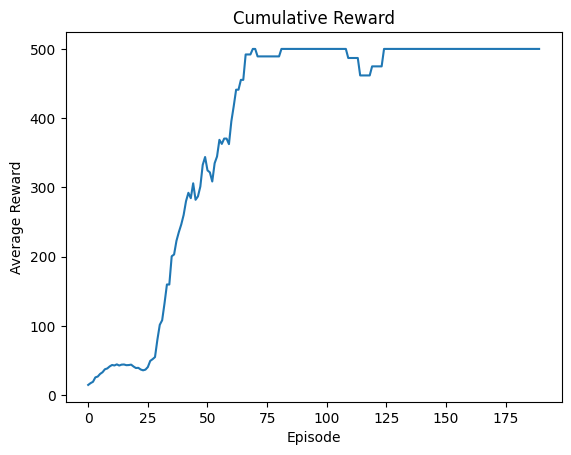

In [187]:
avg_rewards = [np.mean(rewards[i - 10 : i]) for i in range(10, len(rewards))]
plt.plot(avg_rewards)
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.title("Cumulative Reward")
plt.show()

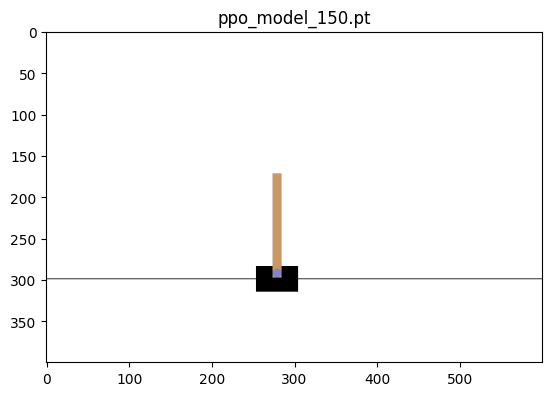

In [190]:
from pathlib import Path

import matplotlib.pyplot as plt
from IPython import display

%matplotlib inline

for model_file in sorted(
    list(Path(".").glob("ppo_model_*.pt")), key=lambda x: int(x.stem.split("_")[2])
):
    print(model_file)
    model = ActorCriticNetwork(STATE_SIZE, ACTION_SIZE).to(device)
    model.load_state_dict(torch.load(model_file))
    model.eval()

    env = gym.make("CartPole-v1", render_mode="rgb_array")
    state, _ = env.reset()
    done = False
    img = plt.imshow(env.render())
    plt.title(model_file)
    while not done:
        img.set_data(env.render())
        display.display(plt.gcf())
        display.clear_output(wait=True)

        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        action = torch.argmax(model(state)[0]).item()
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        time.sleep(1 / 144)
    env.close()